In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [50]:
tickers = ['AAPL']
data = yf.download(tickers, start = '2024-01-01', end = '2025-4-17')
data = data['Close']
df = pd.DataFrame(data)
df.tail()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2025-04-10,190.419998
2025-04-11,198.149994
2025-04-14,202.520004
2025-04-15,202.139999
2025-04-16,194.270004


In [51]:
df['Log Returns'] = np.log(df['AAPL']/df['AAPL'].shift(1))
df = df.dropna()
df.tail()

Ticker,AAPL,Log Returns
Date,,
2025-04-10,190.419998,-0.043319
2025-04-11,198.149994,0.039792
2025-04-14,202.520004,0.021814
2025-04-15,202.139999,-0.001878
2025-04-16,194.270004,-0.039712


Calculating the Parameters

In [52]:
S_0 = float(df['AAPL'].iloc[-1])
print(f'S0 Value: {S_0}')
sigma_annual = float((df['Log Returns'].std())*np.sqrt(252))
print(f'Sigma Annual: {sigma_annual}')

S0 Value: 194.27000427246094
Sigma Annual: 0.29987399745796955


In [53]:
t_bills = yf.download("^IRX", start="2024-01-01", end="2025-04-17")
r = float(t_bills['Close'].iloc[-1]/100)
print(f'Risk-Free Rate: {r}')

[*********************100%***********************]  1 of 1 completed

Risk-Free Rate: 0.04208000183105469



C:\Users\LiamRodgers\AppData\Local\Temp\ipykernel_12144\1677575590.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r = float(t_bills['Close'].iloc[-1]/100)


In [54]:
print(f'S_0: {S_0}\nSigma Annual: {sigma_annual}\nRisk Free Rate: {r} ')

S_0: 194.27000427246094
Sigma Annual: 0.29987399745796955
Risk Free Rate: 0.04208000183105469 


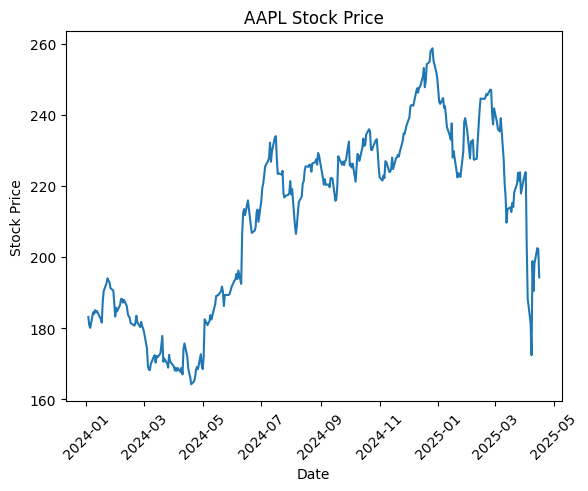

In [55]:
plt.plot(df.index, df['AAPL'])
plt.title('AAPL Stock Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.show()

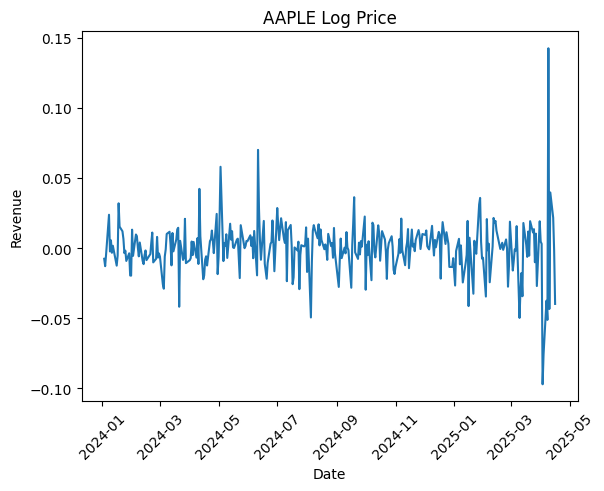

In [56]:
plt.plot(df.index, df['Log Returns'])
plt.title('AAPLE Log Price')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation = 45)
plt.show()

Binomial Tree Model

In [57]:
def binomial_american_option(S0, K, T, r, sigma, N, option_type="put", american=True):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    ST = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # Option values at maturity
    if option_type == "call":
        V = np.maximum(ST - K, 0)
    else:
        V = np.maximum(K - ST, 0)

    # Step backward through tree
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            ST_i = S0 * (u ** i) * (d ** (t - i))
            exercise = max(K - ST_i, 0) if option_type == "put" else max(ST_i - K, 0)
            hold = np.exp(-r * dt) * (q * V[i + 1] + (1 - q) * V[i])
            V[i] = max(exercise, hold) if american else hold

    return V[0]

In [58]:
K = 195       # strike price (adjust if needed)
T = 1 / 12    # 1 month to expiration
N = 100       # time steps
option_type = "put"

price = binomial_american_option(S_0, K, T, r, sigma_annual, N, option_type=option_type)

print(f"""S_0: {S_0}
Sigma Annual: {sigma_annual}
Risk Free Rate: {r}

Binomial American {option_type.title()} Option Price: {price:.4f}
""")

S_0: 194.27000427246094
Sigma Annual: 0.29987399745796955
Risk Free Rate: 0.04208000183105469

Binomial American Put Option Price: 6.7887



In [59]:
for steps in [25, 50, 100, 200]:
    p = binomial_american_option(S_0, K, T, r, sigma_annual, steps, option_type)
    print(f"Steps: {steps}, Price: {p:.4f}")

Steps: 25, Price: 6.8439
Steps: 50, Price: 6.7875
Steps: 100, Price: 6.7887
Steps: 200, Price: 6.7869


The Greeks

In [60]:
h = 0.1 #stock bump
price_up = binomial_american_option(S_0 + h, K, T, r, sigma_annual, N, option_type=option_type)
price_down = binomial_american_option(S_0 - h, K, T, r, sigma_annual, N, option_type=option_type)

In [61]:
Delta = (price_up-price_down)/2*h
Gamma = (price_up - 2*price + price_down)/h**2
print(f'Delta: {Delta}\nGamma: {Gamma}')

Delta: -0.005094023143144489
Gamma: 0.0016674989304910068


In [ ]:
change = 5 #h value which is the change in the stock price
stock_prices = np.linspace(S_0 - change, S_0 + change, 20)
deltas = []
gammas = []

for S in stock_prices:
    price_up = binomial_american_option(S + h, K, T, r, sigma_annual, N, option_type=option_type)
    price_down = binomial_american_option(S - h, K, T, r, sigma_annual, N, option_type=option_type)
    price = binomial_american_option(S, K, T, r, sigma_annual, N, option_type=option_type)
    delta = (price_up - price_down) / (2 * h)
    gamma = (price_up - 2*price + price_down)/h**2 
    deltas.append(delta)
    gammas.append(gamma)

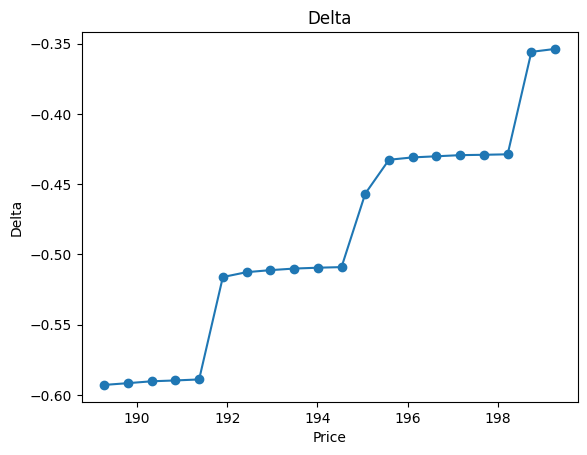

In [63]:
plt.plot(stock_prices, deltas, marker = 'o')
plt.title('Delta')
plt.ylabel('Delta')
plt.xlabel('Price')
plt.show()

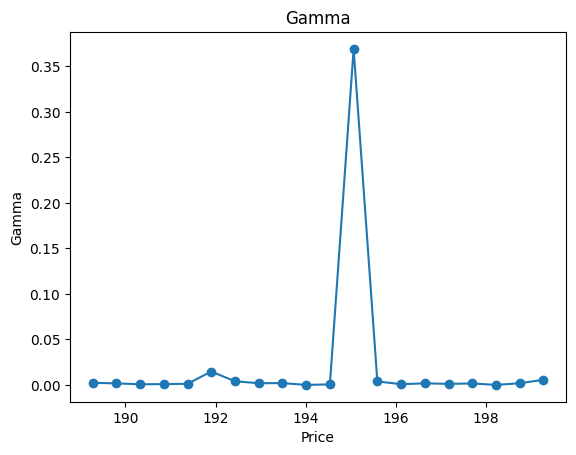

In [64]:
plt.plot(stock_prices, gammas, marker = "o")
plt.title('Gamma')
plt.ylabel('Gamma')
plt.xlabel('Price')
plt.show()